In [ ]:
import pandas as pd
import sys
sys.path.append('./src') 
import engineer_features as ef
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
import optuna

c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [13]:
X_train, X_test, y_train, y_test = ef.engineer_features(df, use_linear_model=False, use_smote=True)
print(f"Resampled training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Strategy: Using ORIGINAL amount. Dropping 'log_transaction_amount'.
Feature engineering complete.
Before SMOTE:
Is Fraudulent
0    17929
1      978
Name: count, dtype: int64

After SMOTE:
Is Fraudulent
0    17929
1    17929
Name: count, dtype: int64
Resampled training features shape: (35858, 24)
Test features shape: (4727, 24)


c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\src\engineer_features.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_avg_spend_before_tx'].fillna(0, inplace=True)


In [14]:
def objective(trial):
    # Define the hyperparameters to search
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }
    
    # Create the model with the suggested params
    model = RandomForestClassifier(
        **params,
        random_state=ef.RANDOM_SEED,
        n_jobs=-1
    )
    
    # Get the cross-validation score (on the training data)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    # Return the mean score for this trial
    return score.mean()

In [18]:
# Maximise ROC-AUC Score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Run 20 trials

print(f"Best ROC-AUC: {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)

best_rf_model = RandomForestClassifier(
    **study.best_params,  # Use the best params found by Optuna
    random_state=ef.RANDOM_SEED,
    n_jobs=-1
)
best_rf_model.fit(X_train, y_train)

[I 2025-11-15 16:24:41,667] A new study created in memory with name: no-name-2645d3cb-8821-4bf4-81ee-53f9226a811b
[I 2025-11-15 16:24:43,071] Trial 0 finished with value: 0.9753318043699567 and parameters: {'n_estimators': 241, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9753318043699567.
[I 2025-11-15 16:24:44,578] Trial 1 finished with value: 0.9730006591783709 and parameters: {'n_estimators': 266, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9753318043699567.
[I 2025-11-15 16:24:46,043] Trial 2 finished with value: 0.9791675620458752 and parameters: {'n_estimators': 241, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.9791675620458752.
[I 2025-11-15 16:24:48,947] Trial 3 finished with value: 0.9861400325933483 and parameters: {'n_estimators': 435, 'max_depth': 24,

Best ROC-AUC: 0.9928
Best Parameters:
{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


,n_estimators,100
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



--- Evaluation of Best Model (Test Set) ---
Accuracy (Test Set): 0.9355
ROC-AUC Score (Test Set): 0.7375

Classification Report (Test Set):
               precision    recall  f1-score   support

Not Fraud (0)       0.96      0.97      0.97      4483
    Fraud (1)       0.33      0.25      0.29       244

     accuracy                           0.94      4727
    macro avg       0.65      0.61      0.63      4727
 weighted avg       0.93      0.94      0.93      4727


Confusion Matrix (Test Set):


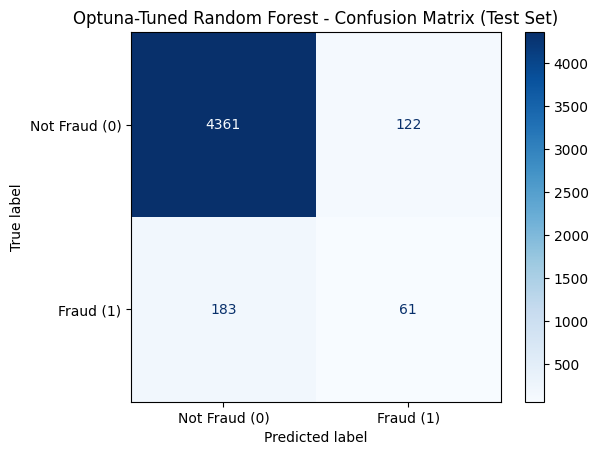

In [16]:
print("\n--- Evaluation of Best Model (Test Set) ---")
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy (Test Set): {accuracy:.4f}")
print(f"ROC-AUC Score (Test Set): {roc_auc:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud (0)', 'Fraud (1)'])
disp.plot(cmap='Blues')
plt.title("Optuna-Tuned Random Forest - Confusion Matrix (Test Set)")
plt.show()

In [17]:
print("\n--- Top 10 Feature Importances (Tuned Model) ---")
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))


--- Top 10 Feature Importances (Tuned Model) ---
                         feature  importance
3               Account Age Days    0.137350
0             Transaction Amount    0.118695
6                 is_new_account    0.070546
4               Transaction Hour    0.069360
11              amount_deviation    0.049097
19            Device Used_mobile    0.041864
1                       Quantity    0.041647
12  Payment Method_bank transfer    0.039909
20            Device Used_tablet    0.038360
23              Hour_Bin_Evening    0.035033
